## FedAvg Simulation with TensorFlow
In this notebook, we will implement FedAvg from scratch.
We will:
* Partition the data across simulated clients
* Visualize data partitions
* Define and instantiate a simple CNN model
* Write and run the FedAvg algorithm
* Empirically validate the effect of data heterogeneity

Firstly, we import the libraries we need.

In [1]:
# This for ML part
import tensorflow as tf
import numpy as np

# This just to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

We define some constants that we will use later on.

In [2]:
TOTAL_CLIENTS = 10
LOCAL_EPOCHS = 1
BATCH_SIZE = 32
ACTIVE_CLIENTS = 0.5

# LEARNING_RATE = 0.1

We define a helper function that just visualize in a nice way the data distributions of clients.

In [3]:
def draw_label_distribuitions(partitions, num_classes = 10):
    """Draw a chart based on the data partitions passed in."""
    
    list_label_counter = []
    for client_distrib in partitions:
        label_counter = Counter()
        # Iterate over the dataset to count each label
        for _, label in client_distrib:
            label_counter[int(label.numpy())] += 1
    
        # Display the label counts
        print("Label occurrences:", label_counter)
        list_label_counter.append(label_counter)
    
    
    data = np.array([[partition.get(label, 0) for label in range(num_classes)] for partition in list_label_counter])

    # Stacked Bar Chart
    fig, ax = plt.subplots(figsize=(10, 6))

    # Number of partitions
    num_partitions = len(partitions)

    # Define colors for each class
    colors = plt.cm.get_cmap('tab10', num_classes).colors

    # Initialize the bottom of the stack
    bottom = np.zeros(num_partitions)

    # Plot stacked bars for each class
    for i in range(num_classes):
        ax.bar(np.arange(num_partitions), data[:, i], bottom=bottom, label=f'Class {i}', color=colors[i])
        bottom += data[:, i]

    # Add labels and title
    ax.set_title('Class Distribution Across Clients')
    ax.set_xlabel('Client ID')
    ax.set_ylabel('Number of Samples')
    ax.set_xticks(np.arange(num_partitions))
    ax.set_xticklabels([f'Client {i}' for i in range(num_partitions)])
    # ax.legend(title='Class')
    ax.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    # Show the plot
    # plt.tight_layout()
    plt.show()

We define the model architecture we will use, just a simple 4-layer CNN (2 conv, 2 dense).

In [4]:
class CNNModel(tf.keras.Model):
    def __init__(self, only_digits=True, seed=1):
        super().__init__()
        data_format = 'channels_last'
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                                            padding='same', activation=tf.nn.relu,
                                            kernel_initializer=tf.keras.initializers.HeNormal(
                                                seed=seed),
                                            )

        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1),
                                            padding='same', activation=tf.nn.relu,
                                            kernel_initializer=tf.keras.initializers.HeNormal(
                                                seed=seed),
                                            )
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same',
                                                  data_format=data_format)
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same',
                                                  data_format=data_format)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(10 if only_digits else 47)


    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x


def create_cnn_model(only_digits=True, seed=1):
    """The CNN model used in https://arxiv.org/abs/1602.05629.
    Args:
      only_digits: If True, uses a final layer with 10 outputs, for use with the
        digits only EMNIST dataset or FMNIST. If False, uses 62 outputs for the larger
        dataset.
    Returns:
      An uncompiled `tf.keras.Model`.
    """
    print("Create CNN")
    input_shape = [None, 28, 28,1]
    model = CNNModel()
    model.build(input_shape)
    return model

temp_model = create_cnn_model()
temp_model.predict(np.random.random((1, 28, 28, 1)))
temp_model.summary()

Create CNN



1/1 [==============================] - 0s 374ms/step
Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  832       
                                                                 
 conv2d_1 (Conv2D)           multiple                  51264     
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           multiple                  0         
                                                        

In [5]:
temp_model_weights = temp_model.get_weights()

print(f"Weights len: {len(temp_model_weights)}")

print("\n Model updates would have this shape (at least this size). If not compressed. \n")
for layer in temp_model.layers:
    if len(layer.get_weights()) > 0: 
        weights = layer.get_weights()[0]
        print(f"weights shape {weights.shape}")
        bias = layer.get_weights()[1]
        print(f"bias shape {bias.shape}")



Weights len: 8

 Model updates would have this shape (at least this size). If not compressed. 

weights shape (5, 5, 1, 32)
bias shape (32,)
weights shape (5, 5, 32, 64)
bias shape (64,)
weights shape (3136, 512)
bias shape (512,)
weights shape (512, 10)
bias shape (10,)


Partition of data and pre-processing.
`divide_data` just assign a specific number of local classes to each client.

In [6]:
# Utility functions
def expand_dims(image, label):
      return tf.expand_dims(image, axis=-1), label


def divide_data(num_client=1, num_local_class=10, dataset_name='fashion_mnist', i_seed=0, num_classes=10):
    """
    Method to divide data in each client
    :param num_client: Total number of client
    :param num_local_class: Number of the local classes in each client
    :param dataset_name:
    :param i_seed:
    :param num_classes: Total number of classes in the original dataset (dataset_name)
    :return: Dataset of all clients
    """

    (train_data, train_targets), (test_data, test_targets) = tf.keras.datasets.fashion_mnist.load_data()

    # Data normalization
    train_data = train_data/255.0
    test_data = test_data/255.0

    print("x_train shape: ", train_data[0].shape)

    # import pdb; pdb.set_trace()
    if num_local_class == -1:
        num_local_class = num_classes
    assert 0 < num_local_class <= num_classes, "number of local class should smaller than global number of class"

    config_division = {}  # Count of the classes for division
    config_class = {}  # Configuration of class distribution in clients
    config_data = {}  # Configuration of data indexes for each class : Config_data[cls] = [0, []] | pointer and indexes

    for i in range(num_client):
        config_class['f_{0:05d}'.format(i)] = []
        for j in range(num_local_class):
            cls = (i+j) % num_classes
            if cls not in config_division:
                config_division[cls] = 1
                config_data[cls] = [0, []]

            else:
                config_division[cls] += 1
            config_class['f_{0:05d}'.format(i)].append(cls)

    for cls in config_division.keys():
        indexes = tf.where(tf.equal(train_targets, cls))
        num_datapoint = indexes.shape[0]
        indexes = tf.random.shuffle(indexes)
        num_partition = num_datapoint // config_division[cls]
        for i_partition in range(config_division[cls]):
            if i_partition == config_division[cls] - 1:
                config_data[cls][1].append(indexes[i_partition * num_partition:])
            else:
                config_data[cls][1].append(indexes[i_partition * num_partition: (i_partition + 1) * num_partition])
    clients_data = []

    for user in (config_class.keys()):
        user_data_indexes = tf.constant([], dtype=tf.int64, shape=[0, 1])
        for cls in config_class[user]:
            user_data_index = config_data[cls][1][config_data[cls][0]]
            user_data_indexes = tf.concat([user_data_indexes, user_data_index],axis=0)
            config_data[cls][0] += 1

        user_data_indexes = tf.squeeze(user_data_indexes)
        # print(user_data_indexes.shape)
        user_data_indexes = tf.cast(user_data_indexes, dtype=tf.int64)
        user_data_indexes = user_data_indexes.numpy().tolist()


        user_data = tf.gather(train_data, user_data_indexes)
        user_targets = tf.gather(train_targets, user_data_indexes)

        clients_data.append(tf.data.Dataset.from_tensor_slices((user_data,  user_targets)).map(expand_dims))

    test_data = tf.data.Dataset.from_tensor_slices((test_data,  test_targets)).map(expand_dims)

    return clients_data, test_data


### FedAvg algorithm


In [7]:
def main_fedavg(clients_data, test_data, total_rounds):
    # Initialize the server model
    server_model = create_cnn_model()
    server_model.predict(np.random.random((1, 28, 28, 1)))
    server_model.compile(optimizer='sgd',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(
                                from_logits=True),
                         metrics=['accuracy'])
    test_data = test_data.batch(128)
    test_loss, test_acc = server_model.evaluate(test_data)
    print(f'[Server] Before starting -- Test accuracy: {test_acc}')

    for r in range(total_rounds):
        print(f"Start round: {r} ")
        delta_w_aggregated = tf.nest.map_structure(lambda a, b: a - b,
                                                   server_model.get_weights(),
                                                   server_model.get_weights())
        # Client selection
        m = max(TOTAL_CLIENTS * ACTIVE_CLIENTS, 1)
        client_list = list(range(TOTAL_CLIENTS))

        sampled_clients = np.random.choice(
            np.asarray(client_list, np.int32),
            size=int(m),
            replace=False)

        print(sampled_clients)

        total_samples = 0
        for client in sampled_clients:
          total_samples += tf.data.experimental.cardinality(clients_data[client])

        for client in sampled_clients:
            global_weights = server_model.get_weights()
            updated_weights, local_samples = client_update(global_weights, clients_data[client], client, r)

            # Scaling the model updates
            # According to the amount of local data samples
            delta_w_aggregated = tf.nest.map_structure(
                lambda a, b: a + b * (local_samples / total_samples),
                delta_w_aggregated,
                updated_weights)

        # apply the aggregated updates
        # --> sgd with 1.0 lr
        new_global_weights = tf.nest.map_structure(lambda a, b: a + b,
                                                   global_weights,
                                                   delta_w_aggregated)

        # Set the updated server weights for the new round
        server_model.set_weights(new_global_weights)

        # logging global model performance
        test_loss, test_acc = server_model.evaluate(test_data)
        print(f'[Server] Round {r} -- Test accuracy: {test_acc}')
        print("End round ", r)
    return test_acc


def client_update(weights, client_data, client_id, r=0): #, homogeneous=True
    """This implements the local client update and returns
    the weight updates (the difference among the received
    and locally computed weights).
    """
    
    print(f"Update Client {client_id} - round: {r}")
    client_model = create_cnn_model()
    client_model.predict(np.random.random((1, 28, 28, 1)))
    client_model.set_weights(weights)
    client_model.compile(optimizer='sgd',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(
                                from_logits=True),
                        metrics=['accuracy'])

    # Locally train the model
    client_model.fit(client_data.batch(BATCH_SIZE), epochs=LOCAL_EPOCHS)

    local_samples = tf.data.experimental.cardinality(client_data)

    client_weights = client_model.get_weights()
    # Computing the model updates
    delta_w_local = tf.nest.map_structure(lambda a, b: a - b,
                                                  client_weights,
                                                  weights,
                                                  )
    return delta_w_local, local_samples

### FedAvg with Data Heterogeneity
Now, we are going to run 2 different simulations:
* IID data (each client has the same amount of per-label samples).
* Non-IID data (each client has only 4 classes represented locally, no samples for the other 6 labels).

We are interested in the final accuracy of the global model after the same number of rounds.

In [8]:
LOCAL_CLASSES = 10
TOTAL_CLASSES = 10
TOTAL_ROUNDS = 10
clients_data, test_data = divide_data(num_client=10, num_local_class=LOCAL_CLASSES, dataset_name='fashion_mnist', i_seed=0, num_classes=TOTAL_CLASSES)
final_accuracy = main_fedavg(clients_data, test_data, total_rounds=TOTAL_ROUNDS)

x_train shape:  (28, 28)
Create CNN
1/1 [==============================] - 0s 104ms/step


79/79 [==============================] - 2s 16ms/step - loss: 2.5065 - accuracy: 0.1197
[Server] Before starting -- Test accuracy: 0.11969999969005585
Start round: 0 
[0 2 5 1 6]
Update Client 0 - round: 0
Create CNN
188/188 [==============================] - 3s 14ms/step - loss: 0.3999 - accuracy: 0.9358
Update Client 2 - round: 0
Create CNN
188/188 [==============================] - 3s 15ms/step - loss: 0.3861 - accuracy: 0.9365
Update Client 5 - round: 0
Create CNN
188/188 [==============================] - 3s 14ms/step - loss: 0.3955 - accuracy: 0.9418
Update Client 1 - round: 0
Create CNN
188/188 [==============================] - 3s 13ms/step - loss: 0.3669 - accuracy: 0.9323
Update Client 6 - round: 0
Create CNN
79/79 [==============================] - 1s 16ms/step - loss: 1.7482 - accuracy: 0.3857
[Server] Round 0 -- Test accuracy: 0.385699987411499
End round  0
Start round: 1 
[3 2 1 8 0

Label occurrences: Counter({0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600, 8: 600, 9: 600})
Label occurrences: Counter({1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600, 8: 600, 9: 600, 0: 600})
Label occurrences: Counter({2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600, 8: 600, 9: 600, 0: 600, 1: 600})
Label occurrences: Counter({3: 600, 4: 600, 5: 600, 6: 600, 7: 600, 8: 600, 9: 600, 0: 600, 1: 600, 2: 600})
Label occurrences: Counter({4: 600, 5: 600, 6: 600, 7: 600, 8: 600, 9: 600, 0: 600, 1: 600, 2: 600, 3: 600})
Label occurrences: Counter({5: 600, 6: 600, 7: 600, 8: 600, 9: 600, 0: 600, 1: 600, 2: 600, 3: 600, 4: 600})
Label occurrences: Counter({6: 600, 7: 600, 8: 600, 9: 600, 0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600})
Label occurrences: Counter({7: 600, 8: 600, 9: 600, 0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600})
Label occurrences: Counter({8: 600, 9: 600, 0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600})
Label occurrences: 

C:\Users\utente\AppData\Local\Temp\ipykernel_21804\109243901.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes).colors


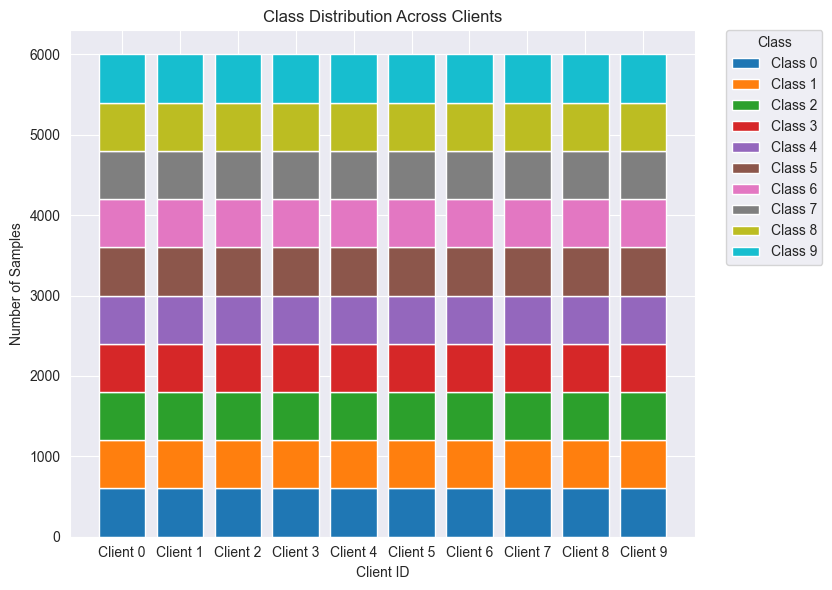

Final model accuracy after 10 round: 0.588100016117096


In [9]:
# Draw the distrib
draw_label_distribuitions(clients_data)
print(f"Final model accuracy after {TOTAL_ROUNDS} round: {final_accuracy}")

In [10]:
LOCAL_CLASSES = 4
TOTAL_CLASSES = 10
TOTAL_ROUNDS = 10
clients_data, test_data = divide_data(num_client=10, num_local_class=LOCAL_CLASSES, dataset_name='fashion_mnist', i_seed=0, num_classes=TOTAL_CLASSES)
final_accuracy = main_fedavg(clients_data, test_data, total_rounds=TOTAL_ROUNDS)

x_train shape:  (28, 28)
Create CNN
79/79 [==============================] - 2s 18ms/step - loss: 2.4865 - accuracy: 0.0763
[Server] Before starting -- Test accuracy: 0.0763000026345253
Start round: 0 
[3 0 8 7 2]
Update Client 3 - round: 0
Create CNN
188/188 [==============================] - 4s 17ms/step - loss: 0.1493 - accuracy: 0.9747
Update Client 0 - round: 0
Create CNN
188/188 [==============================] - 4s 17ms/step - loss: 0.1486 - accuracy: 0.9747
Update Client 8 - round: 0
Create CNN
188/188 [==============================] - 4s 19ms/step - loss: 0.1370 - accuracy: 0.9765
Update Client 7 - round: 0
Create CNN
188/188 [==============================] - 4s 17ms/step - loss: 0.1361 - accuracy: 0.9747
Update Client 2 - round: 0
Create CNN
79/79 [==============================] - 1s 18ms/step - loss: 2.1444 - accuracy: 0.2687
[Server] Round 0 -- Test accuracy: 0.2687000036239624
End round  0
Start round: 1 
[7 1 8 0 4]
Update Client 7 - round: 1
Create CNN
188/188 [======

Label occurrences: Counter({0: 1500, 1: 1500, 2: 1500, 3: 1500})
Label occurrences: Counter({1: 1500, 2: 1500, 3: 1500, 4: 1500})
Label occurrences: Counter({2: 1500, 3: 1500, 4: 1500, 5: 1500})
Label occurrences: Counter({3: 1500, 4: 1500, 5: 1500, 6: 1500})
Label occurrences: Counter({4: 1500, 5: 1500, 6: 1500, 7: 1500})
Label occurrences: Counter({5: 1500, 6: 1500, 7: 1500, 8: 1500})
Label occurrences: Counter({6: 1500, 7: 1500, 8: 1500, 9: 1500})
Label occurrences: Counter({7: 1500, 8: 1500, 9: 1500, 0: 1500})
Label occurrences: Counter({8: 1500, 9: 1500, 0: 1500, 1: 1500})
Label occurrences: Counter({9: 1500, 0: 1500, 1: 1500, 2: 1500})


C:\Users\utente\AppData\Local\Temp\ipykernel_21804\109243901.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes).colors


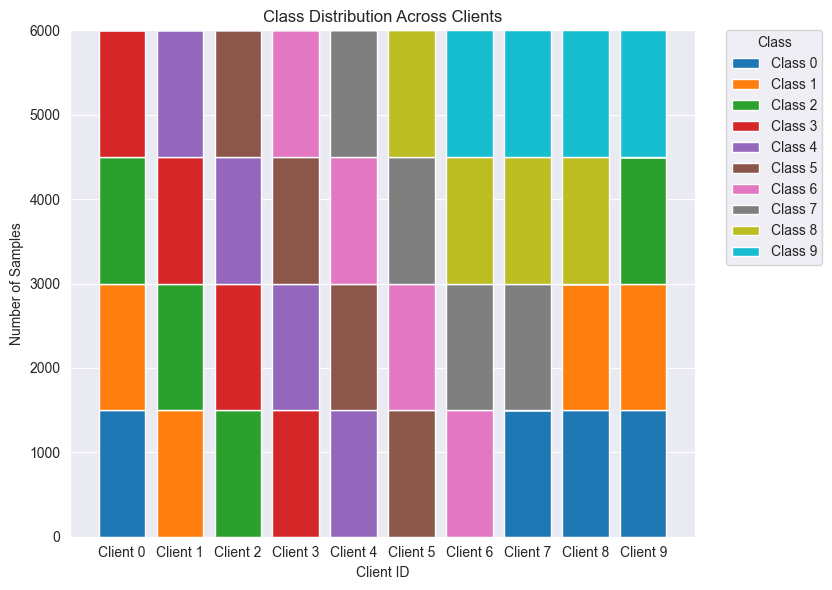

Final model accuracy after 10 round: 0.44429999589920044


In [11]:
# Draw the distrib
draw_label_distribuitions(clients_data)
print(f"Final model accuracy after {TOTAL_ROUNDS} round: {final_accuracy}")